In [1]:
%cd ..

/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import numpy as np
from atl_module.geospatial_utils.raster_interaction import (
    query_raster,
    query_from_lines,
)


In [3]:
aoidflist = []
for aoifile in glob("../data/test_sites/*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined = pd.concat(aoidflist)


In [4]:
secchi_pt_list = []
for file in glob("../data/test_sites/*/secchi_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    secchi_pt_list.append(df)

secchi_pt_combined = pd.concat(secchi_pt_list).reset_index(drop=True)

secchi_pt_combined = secchi_pt_combined.assign(
    X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
)


In [5]:
# tracklines_dflist = [gpd.read_file(file) for file in glob('../data/test_sites/*/tracklines')]

tracklinesdflist = []
for file in glob("../data/test_sites/*/tracklines"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    tracklinesdflist.append(df)

tracklines_combined = pd.concat(tracklinesdflist).reset_index(drop=True)


# Concatenate all bathymetry points from all sites

In [6]:
dflist = []
for file in glob("../data/test_sites/*/all_bathy_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    dflist.append(df)

bathy_pts_df = pd.concat(dflist).reset_index(drop=True).dropna()


## Some stats about all the total batymetry points found

do we see a spike around 2.3 or 4.2 due to ringing?


In [7]:
# set bin edges to encapsulate the location where ringing occurs
binedges = np.arange(-25.05, 0.6, 0.1)
# 2.3 or 4.2 m


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Utopia, Computer Modern Roman, New Century Schoolbook, Century Schoolbook L, ITC Bookman, Bookman, Nimbus Roman No9 L, Times New Roman, Times, Palatino, Charter, serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Utopia, Computer Modern Roman, New Century Schoolbook, Century Schoolbook L, ITC Bookman, Bookman, Nimbus Roman No9 L, Times New Roman, Times, Palatino, Charter, serif


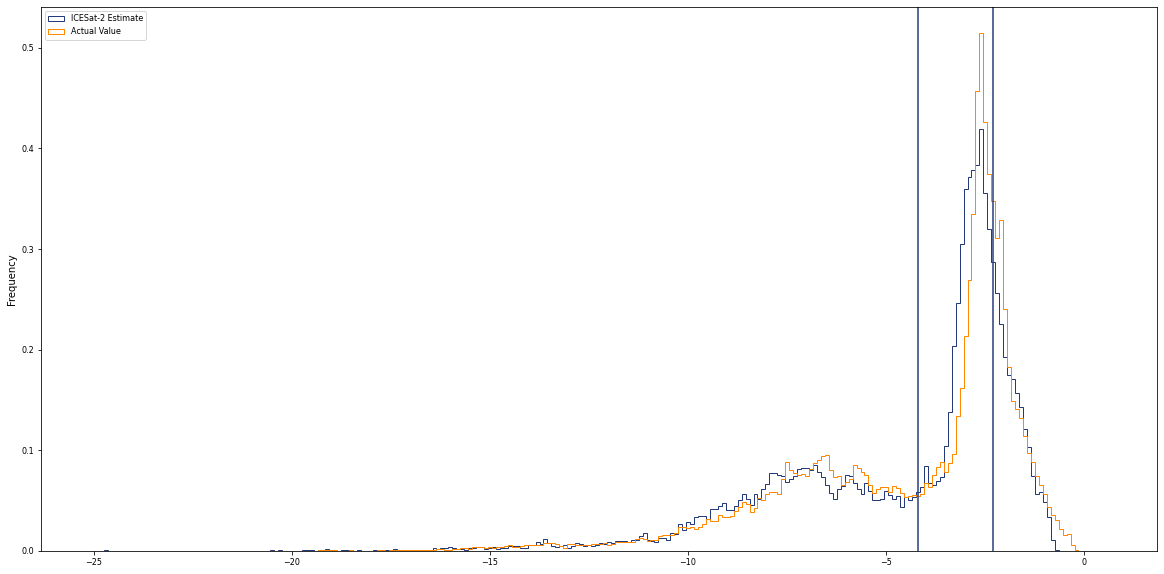

In [8]:
ax = bathy_pts_df.sf_elev_MSL.plot.hist(
    bins=binedges,
    histtype="step",
    density=True,
    label="ICESat-2 Estimate",
    figsize=(20, 10),
)
bathy_pts_df.true_elevation.plot.hist(
    ax=ax, bins=binedges, histtype="step", density=True, label="Actual Value"
)
# ax.set_xlim((-25,0))
ax.axvline(-2.3)
ax.axvline(-4.2)
ax.legend(loc="upper left")


In [9]:
bathy_pts_df.groupby("site").agg(
    {"error": lambda x: np.sqrt(np.mean(np.square(x))), "error_abs": "mean"}
).sort_values("error").round(2)


,error,error_abs
site,,
stcroix,0.54,0.30
oahu8,0.67,0.52
oahu5,0.73,0.50
oahu4,0.75,0.57
big_island,0.78,0.51
florida_keys,0.83,0.32
charlotteamalie,1.09,0.56
oahu7,1.11,0.72
oahu1,1.16,0.77


based on the graph above we do not see significant deviation from the overall distribution of true bathymetry.

# Sites by Secchi Depth

In [10]:
secchi_pt_combined = secchi_pt_combined.assign(
    gebco_elev=query_raster(
        secchi_pt_combined.assign(
            X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
        ),
        "../data/GEBCO/GEBCO_2021_sub_ice_topo.nc",
    )
)
# mask out values based on GEBCO elevation
secchi_pt_combined = secchi_pt_combined[secchi_pt_combined.gebco_elev < 0]


In [11]:
zsd_date_beam = (
    secchi_pt_combined.dropna()
    .groupby(["site", secchi_pt_combined.date, "beam"])
    .mean()
    .reset_index()
)


In [12]:
secchi_pt_combined.loc[:, ["site", "zsd", "sigma_zsd"]].dropna().groupby(
    "site"
).describe()


zsd                                                        \
                  count       mean       std        min        25%        50%   
site                                                                            
big_island        113.0  31.255669  4.686183  22.445070  28.005468  31.954956   
charlotteamalie  1438.0  23.519592  4.663948   8.719503  20.158108  23.515282   
florida_keys      954.0   9.098454  4.504793   2.689436   5.600915   8.286758   
oahu1             271.0  29.390123  7.405490   9.267249  26.395187  29.702919   
oahu2             187.0  31.356634  5.922471  16.962162  28.430064  31.586966   
oahu3             263.0  27.922139  7.416992  11.582570  22.555813  28.434975   
oahu4             162.0  27.687269  9.458749   1.724082  24.194033  28.425524   
oahu5             275.0  30.066747  5.226162  15.181838  26.405718  29.843815   
oahu6              83.0  29.058203  5.423295  17.814608  26.141502  28.927444   
oahu7             172.0  30.446110  6.454633  15.926512  25.633107  32.762161   
oahu8             192.0  33.329513  4.928834  19.053534  30.526306  33.262213   
stcroix           997.0  26.510072  5.451457  11.930245  23.606426  26.890457   

                                      sigma_zsd                        \
                       75%        max     count       mean        std   
site                                                                    
big_island       33.723164  41.398205     113.0  27.884690  17.554555   
charlotteamalie  26.582520  35.288673    1438.0  27.538031  14.436921   
florida_keys     12.343508  23.233147     954.0  56.458615   6.171537   
oahu1            34.944828  42.039185     271.0  31.881881  20.444198   
oahu2            35.448635  41.294418     187.0  29.035026  18.822219   
oahu3            33.376316  40.763424     263.0  37.607033  23.028304   
oahu4            34.969597  39.729691     162.0  38.737653  25.072508   
oahu5            34.337933  39.749001     275.0  28.724290  17.066985   
oahu6            33.093269  38.677238      83.0  32.908554  19.916148   
oahu7            34.566116  39.917496     172.0  29.839069  17.973875   
oahu8            36.800028  43.927235     192.0  25.372708  16.082403   
stcroix          29.822977  38.878567     997.0  36.650862  17.582392   

                                                                        
                       min        25%        50%        75%        max  
site                                                                    
big_island        5.000000  11.800000  22.590000  50.000000  53.099998  
charlotteamalie   5.000000  16.680000  23.920000  38.629997  55.899998  
florida_keys     21.039999  53.317499  56.009998  60.629997  70.809998  
oahu1             5.000000  10.520000  29.519999  53.394999  66.059998  
oahu2             5.000000   5.905000  28.969999  50.020000  57.930000  
oahu3             5.000000  12.985000  50.919998  58.129997  76.919998  
oahu4             5.030000  13.820000  27.139999  61.647498  84.750000  
oahu5             5.000000  12.704999  25.480000  44.149998  61.219997  
oahu6             5.000000  15.809999  31.820000  52.689999  60.219997  
oahu7             5.000000  13.950000  25.539999  51.579998  59.889999  
oahu8             5.000000  10.929999  23.750000  34.562499  55.860001  
stcroix           5.000000  18.600000  41.200001  52.199997  63.090000

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Utopia, Computer Modern Roman, New Century Schoolbook, Century Schoolbook L, ITC Bookman, Bookman, Nimbus Roman No9 L, Times New Roman, Times, Palatino, Charter, serif


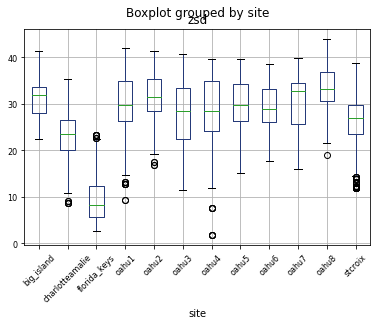

In [13]:
ax = secchi_pt_combined.boxplot(column="zsd", by="site")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


In [14]:
secchi_pt_combined.groupby("site").median()


,zsd,sigma_zsd,X,Y,gebco_elev
site,,,,,
big_island,31.954956,22.590000,-155.932170,19.863307,-37.0
charlotteamalie,23.515282,23.920000,-64.911919,18.345750,-31.0
florida_keys,8.286758,56.009998,-80.986446,24.744184,-3.0
oahu1,29.702919,29.519999,-157.910539,21.276661,-40.0
oahu2,31.586966,28.969999,-157.679485,21.270529,-47.0
oahu3,28.434975,50.919998,-157.682220,21.363550,-29.0
oahu4,28.425524,27.139999,-157.747833,21.474975,-45.0
oahu5,29.843815,25.480000,-157.917571,21.672136,-34.0
oahu6,28.927444,31.820000,-157.987923,21.718169,-39.5


# Analysis of tracklines by site

In [ ]:
tracklines_combined.groupby(["site"]).mean()


# analyzing all bathymetry points from all sites

In [ ]:
# normalize the datetimes so that they can both match each other
bathy_pts_df = bathy_pts_df.assign(date=pd.to_datetime(bathy_pts_df.delta_time).dt.date)
zsd_date_beam = zsd_date_beam.assign(date=pd.to_datetime(zsd_date_beam.date).dt.date)


In [ ]:
joined_df = bathy_pts_df.merge(
    zsd_date_beam, how="outer", on=["beam", "date", "site"]
).drop(columns=["X_y", "Y_y", "gebco_elev_y"])

joined_df = joined_df.assign(depth_ph=joined_df.Z_geoid - joined_df.sea_level_interp)
joined_df


In [ ]:
joined_df = joined_df[joined_df.error_abs < 5]


In [ ]:
joined_df.groupby(["date", "beam"]).count()


It is possible that for each site there will be a 

In [ ]:
tracklines_averaged = joined_df.groupby(["date", "beam"]).mean()
tracklines_averaged


In [ ]:
joined_df.corr("spearman")["error_abs"].sort_values()


In [ ]:
tracklines_averaged.plot.scatter(x="land_sig_conf", y="error_abs")


In [ ]:
tracklines_averaged.plot.scatter(x="oc_hconf_perc", y="error_abs")


In [ ]:
tracklines_averaged[tracklines_averaged.error_abs < 5].plot.scatter(
    x="true_elevation", y="error_abs"
)


In [ ]:
ax = joined_df.plot.scatter(x="kde_val", y="error_abs", alpha=0.01)
# ax.axvline(0.15)


In [ ]:
joined_df.groupby("site").mean().plot.scatter(x="zsd", y="error_abs")


In [ ]:
joined_df.plot.scatter(x="sf_elev_MSL", y="true_elevation")


In [ ]:
# are estimates from areas below the secchi depth worse?
joined_df.groupby(-1 * joined_df.sf_elev_MSL < (joined_df.zsd + 10)).median()


In [ ]:
joined_df.assign(d_below_zsd=(-1 * joined_df.sf_elev_MSL) - joined_df.zsd).plot.scatter(
    x="d_below_zsd", y="error_abs"
)


In [ ]:
errordict = {
    "RMSE": df.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df.true_elevation, df.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df, "All sites combined", errordict)


In [ ]:
ax.a


In [ ]:
df = df[df.true_elevation < 0]
errordict = {
    "RMSE": df.error.pow(2).mean() ** 0.5,
    "R2 Score": r2_score(df.true_elevation, df.sf_elev_MSL),
}
ax = error_lidar_pt_vs_truth_pt(df, "All Sites Excluding mountains", errordict)
ax.get_figure().savefig("../document/figures/all_site_combined_biasplot.jpg")
ax.get_figure().savefig("../document/figures/all_site_combined_biasplot.pdf")

# TODO rasterize scatterplot backgrounds


In [ ]:
df.describe()


In [ ]:
df.groupby(pd.cut(df.true_elevation, 30)).agg(
    {"error": lambda x: np.mean(x**2) ** 0.5}
).rename({"error": "RMS error"})


In [ ]:
tracklines_df = df.groupby([pd.to_datetime(df.delta_time).dt.date, "beam"]).mean()


In [ ]:
tracklines_combined.count()


# 178